# deriving $M_*$ completeness limits

In this notebook I derive the $M_*$ completeness limit. 

I do this by 
1. take best-fit model SEDs of galaxies in $z_i \in [z_0, z_0 + \Delta z]$
2. redshift best-fit model SEDs to $z_i + \Delta z$
3. impose BGS selection function to determine whether it remains in the BGS sample
4. determine $M_*$ where a significant number of galaxies are removed from the sample

In [1]:
import os
import h5py 
import numpy as np
from tqdm.auto import trange
import astropy.table as aTable

from astropy import units as U
from astropy.cosmology import Planck13

/opt/homebrew/anaconda3/envs/bgs/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from provabgs import models as Models
from speclite import filters as specFilter

/Users/federico/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/PhD_project/bgs_psmf/provabgs/src/provabgs/util.py:224: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit
/Users/federico/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/PhD_project/bgs_psmf/provabgs/src/provabgs/models.py:23: UserWarning: import error with fsps; only use emulators
  warnings.warn('import error with fsps; only use emulators')


In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read provabgs catalog

In [4]:
dat_dir = '/Users/federico/OneDrive - University College London/PhD/PhD_project/bgs_psmf/data'

In [5]:
bgs = aTable.Table.read(os.path.join(dat_dir, 'BGS_ANY_full.provabgs.hdf5'))
has_posterior = (bgs['provabgs_z_max'].data != -999.)
is_bgs_bright = bgs['is_bgs_bright']

bgs = bgs[has_posterior & is_bgs_bright]
print('%i BGS Bright galaxies with posteriors' % len(bgs))

143017 BGS Bright galaxies with posteriors


determine $z_0$ and $\Delta z$

(6.5, 13.0)

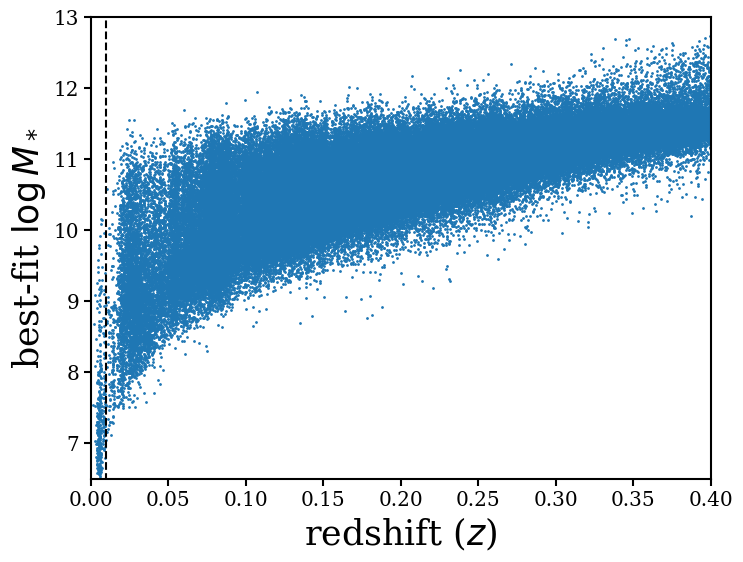

In [6]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(bgs['Z_HP'].data, bgs['provabgs_logMstar_bf'].data, c='C0', s=1)
sub.plot([0.01, 0.01], [6, 13.], c='k', ls='--')
sub.set_xlabel(r"redshift ($z$)", fontsize=25)
sub.set_xlim(0., 0.4)
sub.set_ylabel(r"best-fit $\log M_*$", fontsize=25)
sub.set_ylim(6.5, 13.)

In [7]:
z0 = 0.01
dz = 0.04
for i in range(10): 
    print('%.2f < z < %.2f: %i' % (z0 + dz * i, z0 + dz * (i+1), np.sum((bgs['Z_HP'] > z0 + dz * i) & (bgs['Z_HP'] < z0 + dz * (i+1)))))

0.01 < z < 0.05: 5628
0.05 < z < 0.09: 12629
0.09 < z < 0.13: 15406
0.13 < z < 0.17: 21246
0.17 < z < 0.21: 19811
0.21 < z < 0.25: 18953
0.25 < z < 0.29: 18779
0.29 < z < 0.33: 11949
0.33 < z < 0.37: 7736
0.37 < z < 0.41: 5014


(0.0, 0.5)

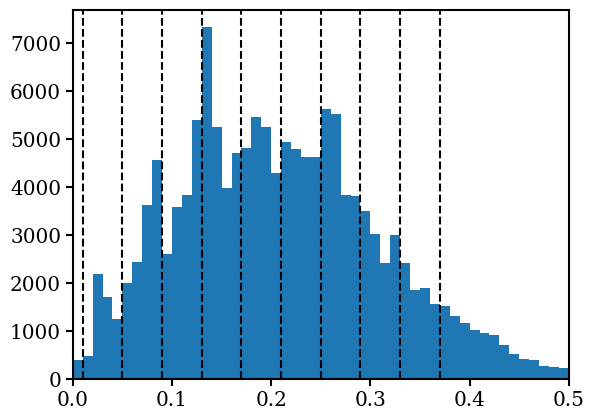

In [8]:
plt.hist(bgs['Z_HP'].data, range=(0., 0.5), bins=50)
for i in range(10):
    plt.axvline(z0+dz*i, color='k', linestyle='--')
plt.xlim(0.00, 0.5)

$z_0 = 0.01$ and $\Delta z = 0.04$ seem sensible.

# calculate $M_{\rm lim}$

In [9]:
m_nmf = Models.NMF(burst=True, emulator=True)

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [10]:
r_pass = specFilter.load_filters('decam2014-r')

def r_mag(w, f):
    ''' calculate r-band magnitude given w, f
    '''
    flux_z, w_z = r_pass.pad_spectrum(np.atleast_2d(f) * 1e-17*U.erg/U.s/U.cm**2/U.Angstrom, w * U.Angstrom)
    maggies = r_pass.get_ab_maggies(flux_z, wavelength=w_z)
    return 22.5 - 2.5 * np.log10(maggies.as_array()[0][0] * 1e9)

In [11]:
def select_z_dz(thetas, zreds, dz=0.025): 
    ''' determine whether (theta, zred) galaxies would be within the sample if redshift
    was increased to zred + dz.
    '''
    dlzs0 = Planck13.luminosity_distance(zreds).to(U.cm).value
    dlzs1 = Planck13.luminosity_distance(zreds + dz).to(U.cm).value

    rmags = [] 
    for theta, zred, dlz0, dlz1 in zip(thetas, zreds, dlzs0, dlzs1): 
        w0, f0 = m_nmf.sed(theta[:-1], zred)

        w1 = w0 / (1 + zred) * (1 + zred + dz)
        f1 = f0 * (dlz0**2 / dlz1**2) * (1 + zred)/(1 + zred + dz)

        rmags.append(r_mag(w1, f1))
    rmags = np.array(rmags)
    return rmags < 19.5

0.010 < z < 0.030


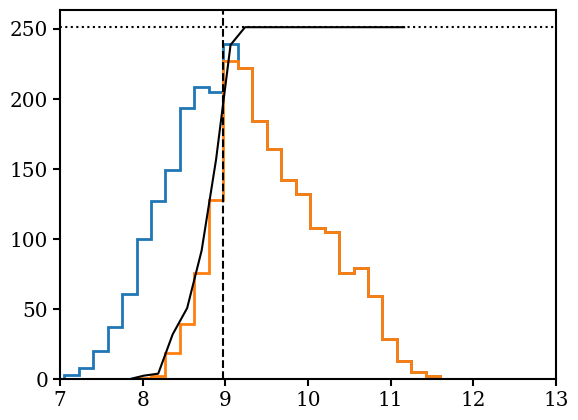

0.030 < z < 0.050


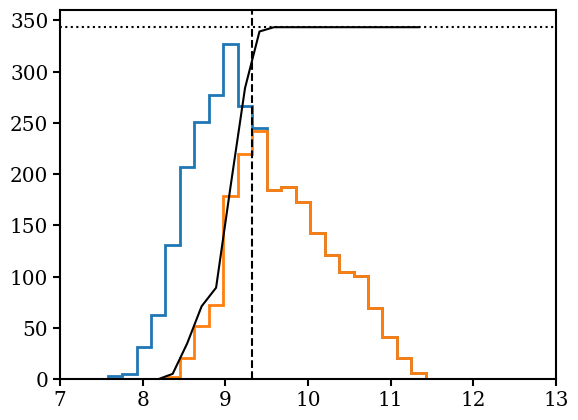

0.050 < z < 0.070


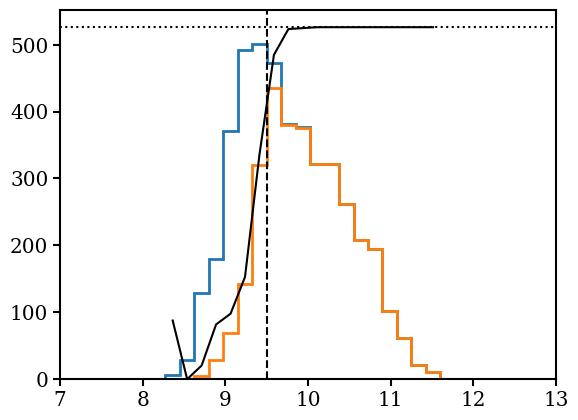

0.070 < z < 0.090


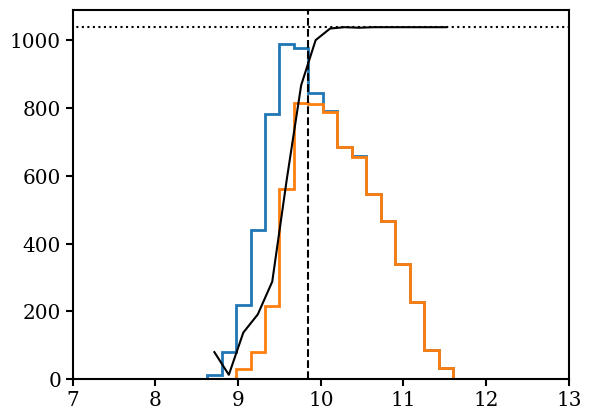

0.090 < z < 0.110


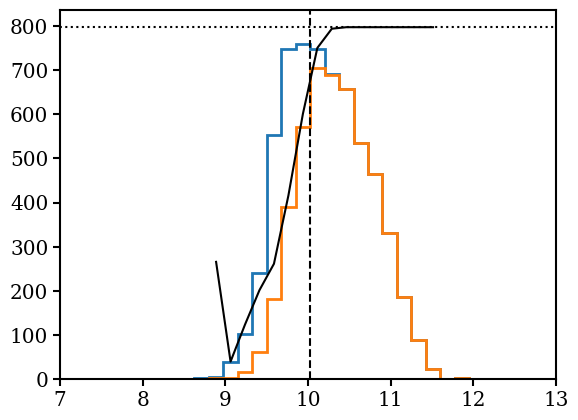

0.110 < z < 0.130


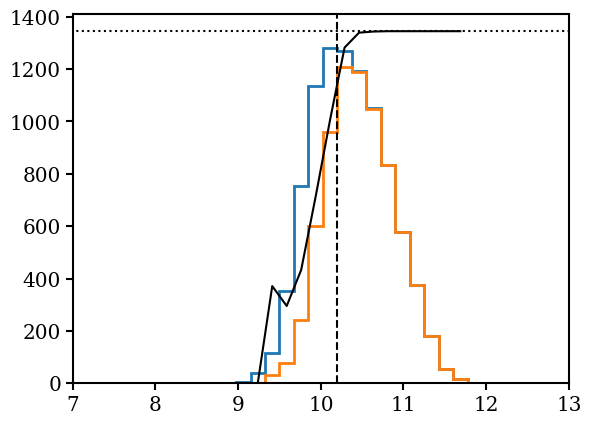

0.130 < z < 0.150


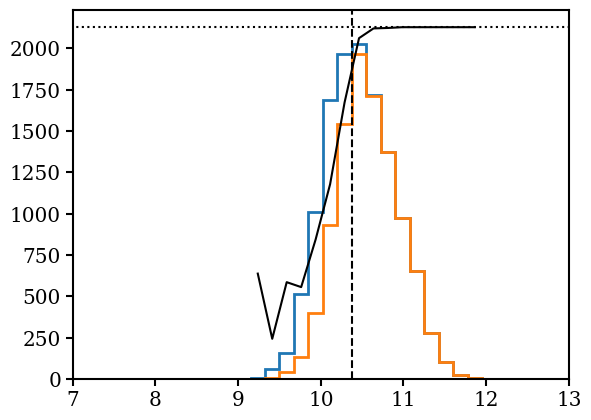

0.150 < z < 0.170


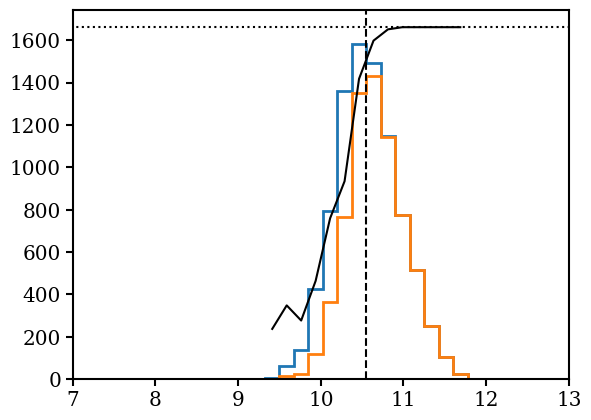

0.170 < z < 0.190


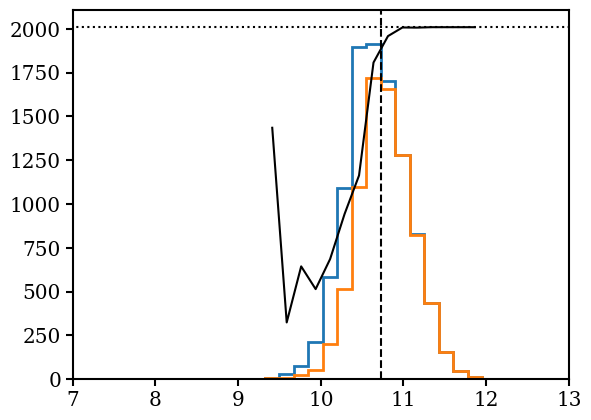

0.190 < z < 0.210


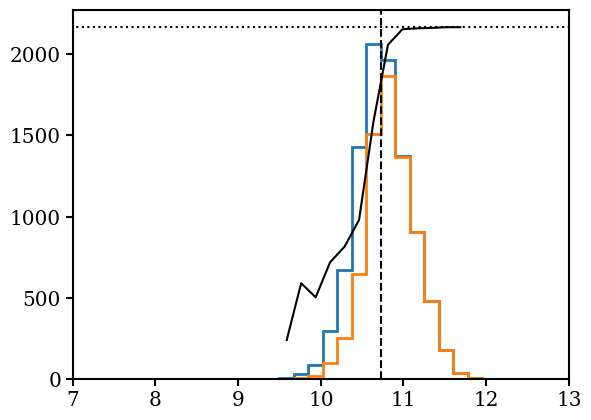

0.210 < z < 0.230


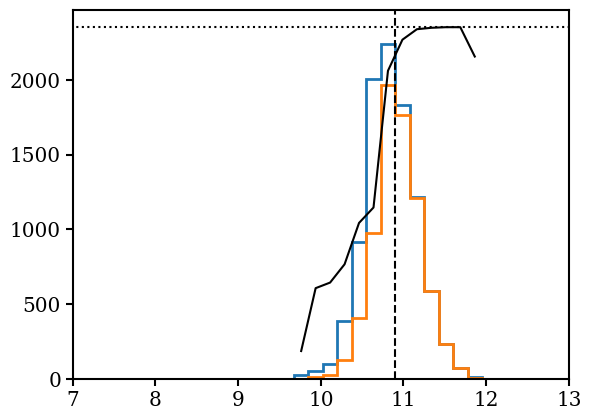

0.230 < z < 0.250


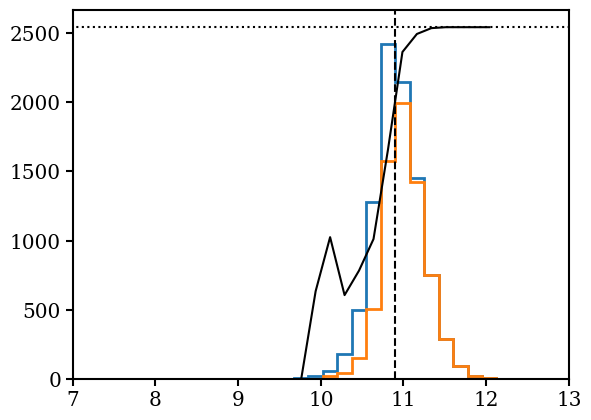

0.250 < z < 0.270


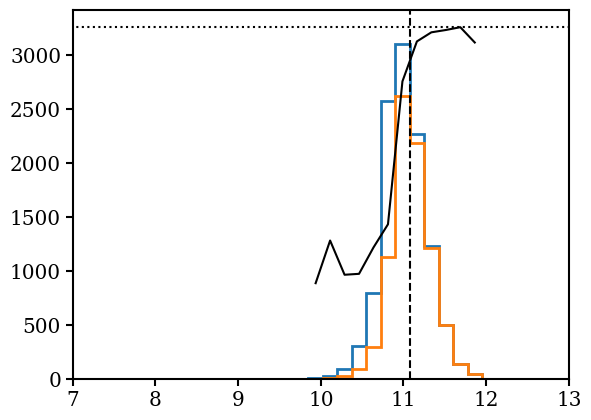

0.270 < z < 0.290


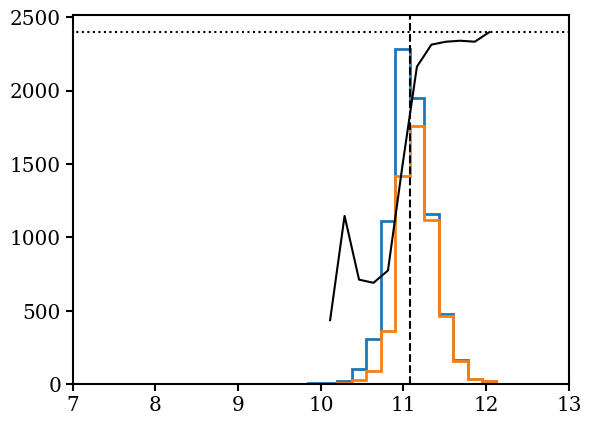

0.290 < z < 0.310


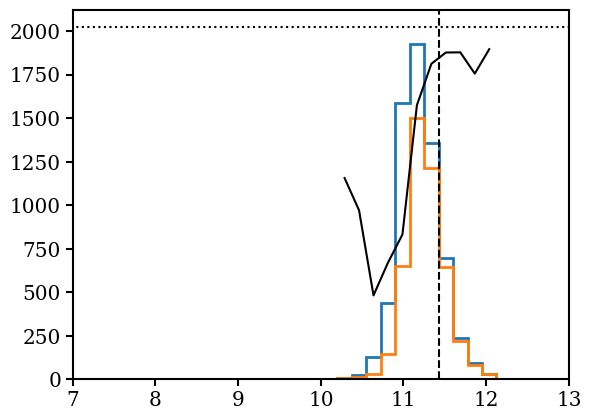

0.310 < z < 0.330


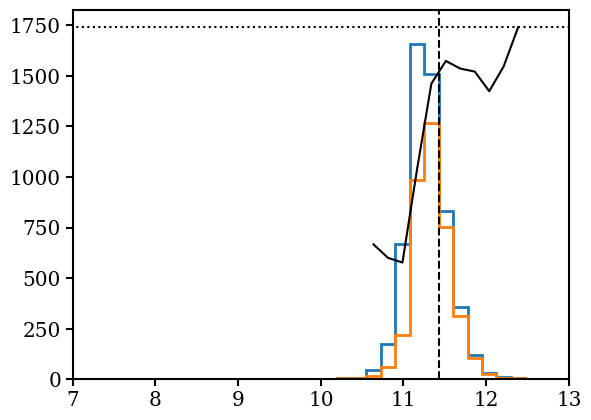

In [12]:
z0 = 0.01
dz = 0.02

zmins = np.array([z0 + iz * dz  for iz in range(16)])
zmaxs = zmins+dz

Mlims = []
for iz in range(16): 
    print('%.3f < z < %.3f' % (zmins[iz], zmaxs[iz]))
    zlim0 = (bgs['Z_HP'].data > zmins[iz]) & (bgs['Z_HP'].data < zmaxs[iz])

    in_zlim1 = select_z_dz(bgs['provabgs_theta_bf'].data[zlim0], bgs['Z_HP'].data[zlim0], dz=dz)

    h0, edges = np.histogram(bgs['provabgs_logMstar_bf'].data[zlim0], range=(6, 13), bins=40)
    h1, _ = np.histogram(bgs['provabgs_logMstar_bf'].data[zlim0][in_zlim1], range=(6, 13), bins=40)

    fcomp = (h1/h0)
    Mlim = (np.min(edges[:-1][(fcomp > 0.9) & (h0 > 5)]))

    _ = plt.hist(bgs['provabgs_logMstar_bf'].data[zlim0], 
                 range=(6, 13), bins=40, histtype='step', linewidth=2)
    _ = plt.hist(bgs['provabgs_logMstar_bf'].data[zlim0][in_zlim1], 
                 range=(6, 13), bins=40, histtype='step', linewidth=2)
    plt.axvline(Mlim, color='k', linestyle='--') 
    
    ymax = plt.gca().get_ylim()[1]
    plt.plot(0.5*(edges[1:] + edges[:-1])[h0 > 5], (h1/h0)[h0 > 5] * ymax, c='k')
    plt.plot([edges[0], edges[-1]], [ymax, ymax], c='k', ls=':')
    
    plt.xlim(7, 13)
    plt.show()
    
    Mlims.append(Mlim)

save the following for demonstration purposes

In [13]:
import pickle

In [14]:
iz = 0
zlim0 = (bgs['Z_HP'].data > zmins[iz]) & (bgs['Z_HP'].data < zmaxs[iz])
in_zlim1 = select_z_dz(bgs['provabgs_theta_bf'].data[zlim0], bgs['Z_HP'].data[zlim0], dz=dz)

with open(os.path.join(dat_dir, 'ms_comp.bgs_bright.demo.p'), 'wb') as fp:
    pickle.dump([bgs['provabgs_logMstar_bf'].data[zlim0], in_zlim1], fp)

# save $\log M_*$ completeness limits to file 

In [15]:
np.savetxt(os.path.join(dat_dir, 'psmf.logmstar_comp_limit.dat'), np.vstack([zmins, zmaxs, np.array([Mlims[0]] + Mlims)[:-1]]).T)